In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

# ===============================
# File paths
# ===============================
dga_malware_file = "/home/ubuntu/DoH_DGA_training/datasets/DGA_HKD/all_pcaps_allN.csv"
doh_tunnel_file = "/home/ubuntu/DoH_DGA_training/datasets/DoH_HKD/DoH-Pcaps/all_pcaps_allN.csv"
dga_malware_synthetic1 = "/home/ubuntu/DoH_DGA_training/datasets/DGA_Google/all_pcaps_allN.csv"
dga_malware_synthetic2 = "/home/ubuntu/DoH_DGA_training/datasets/DGA_CF/all_pcaps_allN.csv"

nondoh_benign_file = "/home/ubuntu/DoH_DGA_training/datasets/PCAPs/DoHBenign-NonDoH/all_nondoh.csv"
doh_benign_file = "/home/ubuntu/DoH_DGA_training/datasets/PCAPs/DoHBenign-NonDoH/all_doh.csv"

# ===============================
# Load datasets
# ===============================
df_dga_malware = pd.read_csv(dga_malware_file)

df_dga_synthetic1 = pd.read_csv(dga_malware_synthetic1)
df_dga_synthetic2 = pd.read_csv(dga_malware_synthetic2)
df_dga_synthetic = pd.concat([df_dga_synthetic1, df_dga_synthetic2], ignore_index=True)

df_doh_tunnel = pd.read_csv(doh_tunnel_file)
df_nondoh_benign = pd.read_csv(nondoh_benign_file)
df_doh_benign = pd.read_csv(doh_benign_file)

# ===============================
# Assign labels
# ===============================
df_dga_malware["label"] = "DGA_MALWARE"
df_dga_synthetic["label"] = "DGA_Synthetic"
df_doh_tunnel["label"] = "DoH_Tunnel"
df_nondoh_benign["label"] = "NonDoH_Benign"
df_doh_benign["label"] = "DoH_Benign"

# ===============================
# Combine all into one DataFrame
# ===============================
df_all = pd.concat(
    [df_dga_malware, df_dga_synthetic, df_doh_tunnel, df_nondoh_benign, df_doh_benign],
    ignore_index=True
)

print("DGA_MALWARE shape:", df_dga_malware.shape)
print("DGA_Synthetic shape:", df_dga_synthetic.shape)
print("DoH_Tunnel shape:", df_doh_tunnel.shape)
print("NonDoH_Benign shape:", df_nondoh_benign.shape)
print("DoH_Benign shape:", df_doh_benign.shape)

print("\nFinal dataset shape:", df_all.shape)
print("Labels distribution:\n", df_all["label"].value_counts())
print("Columns:\n", list(df_all.columns))


DGA_MALWARE shape: (9012, 35)
DGA_Synthetic shape: (203428, 35)
DoH_Tunnel shape: (6008, 36)
NonDoH_Benign shape: (2139204, 36)
DoH_Benign shape: (116412, 36)

Final dataset shape: (2474064, 37)
Labels distribution:
 label
NonDoH_Benign    2139204
DGA_Synthetic     203428
DoH_Benign        116412
DGA_MALWARE         9012
DoH_Tunnel          6008
Name: count, dtype: int64
Columns:
 ['session_id', 'client_ip', 'server_ip', 'client_port', 'server_port', 'protocol', 'N', 'n_client', 'client_bytes', 'client_pkt_min', 'client_pkt_mean', 'client_pkt_max', 'client_iat_min', 'client_iat_mean', 'client_iat_max', 'n_server', 'server_bytes', 'server_pkt_min', 'server_pkt_mean', 'server_pkt_max', 'server_iat_min', 'server_iat_mean', 'server_iat_max', 'pkt_fraction_client', 'bytes_fraction_client', 'flow_duration', 'time_first_response', 'dir_switches', 'size_min', 'size_mean', 'size_max', 'iat_min', 'iat_mean', 'iat_max', 'label', 'pcap_file', 'source_pcap']


In [3]:
N_value = 16   # <-- change this to 8, 16, 32, 64 as needed
df_subset = df_all[df_all["N"] == N_value].copy()

print(f"\nTraining on N={N_value}, dataset size={df_subset.shape[0]}")

# Separate features and target
y = df_subset["label"]
X = df_subset.drop(columns=[
    "label", 'session_id', 'client_ip', 'server_ip', 
    'client_port', 'server_port', 'protocol', 'N',
    'pcap_file', 'source_pcap'
], errors="ignore")
feature_names = X.columns.tolist()
# Keep only numeric features
X = X.select_dtypes(include=["int64", "float64"])

print("Remaining feature columns:\n", list(X.columns))
print("Target classes:", y.unique())


Training on N=16, dataset size=618516
Remaining feature columns:
 ['n_client', 'client_bytes', 'client_pkt_min', 'client_pkt_mean', 'client_pkt_max', 'client_iat_min', 'client_iat_mean', 'client_iat_max', 'n_server', 'server_bytes', 'server_pkt_min', 'server_pkt_mean', 'server_pkt_max', 'server_iat_min', 'server_iat_mean', 'server_iat_max', 'pkt_fraction_client', 'bytes_fraction_client', 'flow_duration', 'time_first_response', 'dir_switches', 'size_min', 'size_mean', 'size_max', 'iat_min', 'iat_mean', 'iat_max']
Target classes: ['DGA_MALWARE' 'DGA_Synthetic' 'DoH_Tunnel' 'NonDoH_Benign' 'DoH_Benign']


In [4]:
# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.3, random_state=42, stratify=y_enc
)

# Standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
# Train MLP
# Extended MLP with more options
mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),   # deeper network with 3 hidden layers
    activation="relu",                  # alternatives: 'tanh', 'logistic'
    solver="adam",                      # alternatives: 'sgd', 'lbfgs'
    alpha=1e-4,                         # L2 regularization (weight decay)
    batch_size=64,                      # mini-batch size
    learning_rate="adaptive",           # 'constant', 'invscaling', 'adaptive'
    learning_rate_init=0.001,           # initial learning rate
    max_iter=500,                       # train longer
    shuffle=True,                       # shuffle samples every epoch
    early_stopping=True,                # stop if validation score doesn’t improve
    validation_fraction=0.1,            # use 10% of training for validation
    n_iter_no_change=20,                # patience for early stopping
    random_state=42,                    # reproducibility
    verbose=True                        # print progress during training
)

mlp.fit(X_train, y_train)

# Evaluate
y_pred = mlp.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Iteration 1, loss = 0.05102676
Validation score: 0.981592
Iteration 2, loss = 0.02726448
Validation score: 0.996004
Iteration 3, loss = 0.02366651
Validation score: 0.995496
Iteration 4, loss = 0.02210419
Validation score: 0.991177
Iteration 5, loss = 0.02076799
Validation score: 0.995011
Iteration 6, loss = 0.01979820
Validation score: 0.991939
Iteration 7, loss = 0.01950161
Validation score: 0.991962
Iteration 8, loss = 0.01840881
Validation score: 0.992355
Iteration 9, loss = 0.01780571
Validation score: 0.991939
Iteration 10, loss = 0.01735677
Validation score: 0.996166
Iteration 11, loss = 0.01800963
Validation score: 0.996836
Iteration 12, loss = 0.01699140
Validation score: 0.997321
Iteration 13, loss = 0.01747616
Validation score: 0.992771
Iteration 14, loss = 0.01679152
Validation score: 0.997598
Iteration 15, loss = 0.01619717
Validation score: 0.992563
Iteration 16, loss = 0.01626905
Validation score: 0.997436
Iteration 17, loss = 0.01565201
Validation score: 0.992494
Iterat

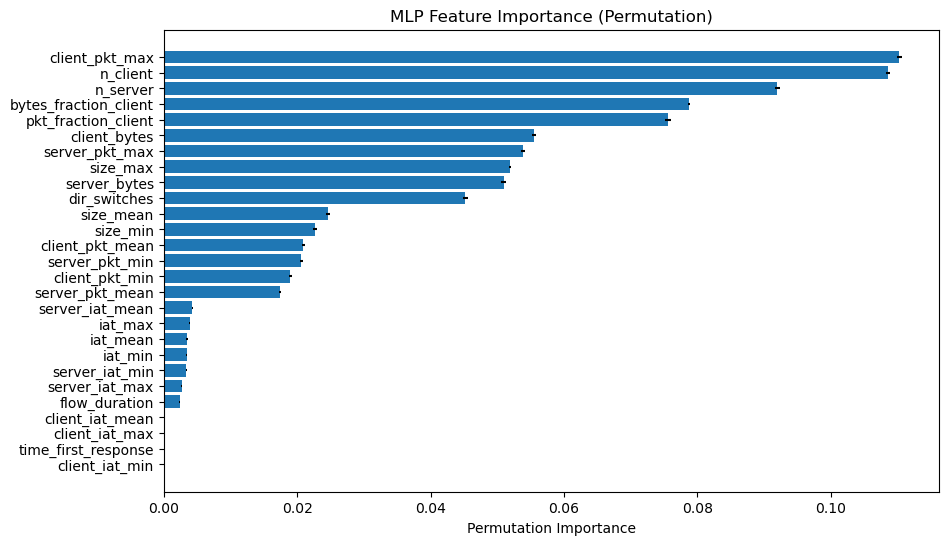

In [6]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import numpy as np
# --- Create generic feature names ---
#feature_names = [f"f{i}" for i in range(X_train.shape[1])]

# Compute permutation importance on test set
result = permutation_importance(
    mlp, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

# Sort by importance
sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(
    range(len(sorted_idx)), 
    result.importances_mean[sorted_idx], 
    xerr=result.importances_std[sorted_idx]
)
plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("MLP Feature Importance (Permutation)")
plt.show()


In [7]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report

# Initialize CatBoost
cat_model = CatBoostClassifier(
    iterations=500,          # number of boosting rounds
    depth=8,                 # tree depth
    learning_rate=0.05,      # learning rate
    loss_function="MultiClass",
    eval_metric="Accuracy",
    random_seed=42,
    verbose=100              # print progress every 100 iters
)

# Train
cat_model.fit(X_train, y_train)

# Predict
y_pred = cat_model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


0:	learn: 0.9920362	total: 176ms	remaining: 1m 27s
100:	learn: 0.9985772	total: 12.3s	remaining: 48.5s
200:	learn: 0.9989491	total: 25.1s	remaining: 37.3s
300:	learn: 0.9990184	total: 37.7s	remaining: 24.9s
400:	learn: 0.9991200	total: 50.2s	remaining: 12.4s
499:	learn: 0.9991685	total: 1m 2s	remaining: 0us

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       676
           1       1.00      1.00      1.00     15257
           2       0.99      1.00      0.99      8731
           3       0.99      1.00      0.99       451
           4       1.00      1.00      1.00    160440

    accuracy                           1.00    185555
   macro avg       1.00      1.00      1.00    185555
weighted avg       1.00      1.00      1.00    185555

